## Import Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

## Read datasets

In [3]:
asm_1_gram = pd.read_csv('asm_features_1_gram_dropped.csv')
asm_2_gram = pd.read_csv('asm_features_2_grams_dropped.csv')
asm_prefix_counts = pd.read_csv('asm_prefix_counts.csv')
bytes_1_gram = pd.read_csv('bytes_features_1_grams.csv')
bytes_2_gram = pd.read_csv('top_170_imp_byte_bigram_df.csv')
file_sizes = pd.read_csv('file_sizes.csv')
dll = pd.read_csv('dll_occurences.csv')
punctuation = pd.read_csv('punctuation_occurences.csv')

In [ ]:
file_sizes.columns

Index(['File ID', 'Bytes File Size', 'ASM File Size', 'Ratio'], dtype='object')

In [4]:
train_labels = pd.read_csv('train_labels.csv')
test_labels = pd.read_csv('test_labels.csv')
train_labels = train_labels.drop('Unnamed: 0', axis=1)
test_labels = test_labels.drop('Unnamed: 0', axis=1)
train_labels = train_labels.rename(columns={'Id':'ID'})
test_labels = test_labels.rename(columns={'Id':'ID'})

## Join datasets into 1 df

In [5]:
def recursive_join(files):
  df = files[0]
  for i in range(1, len(files)):
    # print(i)
    df = df.merge(files[i], on= 'ID', how= 'inner')
    # print(df.head())
  return df


In [6]:
asm_prefix_counts = asm_prefix_counts.rename(columns={'File ID':'ID'})
file_sizes = file_sizes.rename(columns={'File ID':'ID'})
train_labels = train_labels.rename(columns={'Id':'ID'})
test_labels = test_labels.rename(columns={'Id':'ID'})

In [7]:
all_files = [asm_1_gram, asm_2_gram, asm_prefix_counts, bytes_1_gram, bytes_2_gram, file_sizes, dll, punctuation]
asm_files = [asm_1_gram, asm_2_gram, asm_prefix_counts, file_sizes[['ID', 'ASM File Size']], dll, punctuation]
bytes_files = [bytes_1_gram, bytes_2_gram, file_sizes[['ID', 'Bytes File Size']]]


## Data Preprocessing

In [8]:
all_data = recursive_join(all_files)
asm_data = recursive_join(asm_files)
bytes_data = recursive_join(bytes_files)

In [9]:
# Select columns with string (object) data type
string_columns_all = all_data.select_dtypes(include='object').columns.tolist()
string_columns_asm = asm_data.select_dtypes(include='object').columns.tolist()
string_columns_bytes = bytes_data.select_dtypes(include='object').columns.tolist()
#
# print("String columns:", string_columns)

In [10]:
id_col_all = all_data['ID']
all_data = all_data.drop(string_columns_all, axis=1)

id_col_asm = asm_data['ID']
asm_data = asm_data.drop(string_columns_asm, axis=1)

id_col_bytes = bytes_data['ID']
bytes_data = bytes_data.drop(string_columns_bytes, axis=1)

In [ ]:
asm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Columns: 189 entries, add to _
dtypes: int64(189)
memory usage: 2.3 MB


In [11]:
data_normalized_all = pd.DataFrame(tf.math.l2_normalize(all_data, axis=0), columns = all_data.columns)
data_normalized_asm = pd.DataFrame(tf.math.l2_normalize(asm_data.astype('float64'), axis=0), columns = asm_data.columns)
data_normalized_bytes = pd.DataFrame(tf.math.l2_normalize(bytes_data, axis=0), columns = bytes_data.columns)

# Add ID column back
data_normalized_all = pd.concat([id_col_all, data_normalized_all], axis=1)
data_normalized_asm = pd.concat([id_col_asm, data_normalized_asm], axis=1)
data_normalized_bytes = pd.concat([id_col_bytes, data_normalized_bytes], axis=1)


## Train Test Split

In [12]:
train_data_all = pd.merge(train_labels, data_normalized_all, on='ID', how='inner').sort_values(by='ID', key=lambda x: x.str.lower())
test_data_all = pd.merge(test_labels, data_normalized_all, on='ID', how='inner').sort_values(by='ID', key=lambda x: x.str.lower())
train_data_asm = pd.merge(train_labels, data_normalized_asm, on='ID', how='inner').sort_values(by='ID', key=lambda x: x.str.lower())
test_data_asm = pd.merge(test_labels, data_normalized_asm, on='ID', how='inner').sort_values(by='ID', key=lambda x: x.str.lower())
train_data_bytes = pd.merge(train_labels, data_normalized_bytes, on='ID', how='inner').sort_values(by='ID', key=lambda x: x.str.lower())
test_data_bytes = pd.merge(test_labels, data_normalized_bytes, on='ID', how='inner').sort_values(by='ID', key=lambda x: x.str.lower())


In [13]:
y_train_all = train_data_all['Class']
y_test_all = test_data_all['Class']
y_train_asm = train_data_asm['Class']
y_test_asm = test_data_asm['Class']
y_train_bytes = train_data_bytes['Class']
y_test_bytes = test_data_bytes['Class']


In [14]:
X_train_all = train_data_all.drop(['ID', 'Class'], axis=1).fillna(0)
X_test_all = test_data_all.drop(['ID', 'Class'], axis=1).fillna(0)
X_train_asm = train_data_asm.drop(['ID', 'Class'], axis=1).fillna(0)
X_test_asm = test_data_asm.drop(['ID', 'Class'], axis=1).fillna(0)
X_train_bytes = train_data_bytes.drop(['ID', 'Class'], axis=1).fillna(0)
X_test_bytes = test_data_bytes.drop(['ID', 'Class'], axis=1).fillna(0)

In [15]:
import numpy as np
def one_hot_encode(labels):
    labels = np.array(labels)
    labels[labels < 5] = labels[labels < 5] - 1
    labels[labels > 5] = labels[labels > 5] - 2
    encoded_labels = np.identity(8)[labels]
    return encoded_labels

In [16]:
y_train_one_hot_all = one_hot_encode(y_train_all)
y_test_one_hot_all = one_hot_encode(y_test_all)
y_train_one_hot_asm = one_hot_encode(y_train_asm)
y_test_one_hot_asm = one_hot_encode(y_test_asm)
y_train_one_hot_bytes = one_hot_encode(y_train_bytes)
y_test_one_hot_bytes = one_hot_encode(y_test_bytes)

## MLP

In [ ]:
len(X_train_bytes.columns)

428

In [ ]:
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import leaky_relu
from tensorflow.keras.initializers import HeNormal

model_all = Sequential([
    Dense(64, input_shape=(618,), activation='leaky_relu', kernel_regularizer=L2(0.001), kernel_initializer=HeNormal()),
    Dense(128, activation='leaky_relu', kernel_regularizer=L2(0.001)),
    Dense(64, activation='leaky_relu', kernel_regularizer=L2(0.001)),
    Dense(32, activation='leaky_relu', kernel_regularizer=L2(0.001)),
    Dense(8, activation='softmax')
]
)

model_asm = Sequential([
    Dense(64, input_shape=(189,), activation='leaky_relu', kernel_regularizer=L2(0.001), kernel_initializer=HeNormal()),
    Dense(128, activation='leaky_relu', kernel_regularizer=L2(0.001)),
    Dense(64, activation='leaky_relu', kernel_regularizer=L2(0.001)),
    Dense(32, activation='leaky_relu', kernel_regularizer=L2(0.001)),
    Dense(8, activation='softmax')
]
)

model_bytes = Sequential([
    Dense(64, input_shape=(428,), activation='leaky_relu', kernel_regularizer=L2(0.001), kernel_initializer=HeNormal()),
    Dense(128, activation='leaky_relu', kernel_regularizer=L2(0.001)),
    Dense(64, activation='leaky_relu', kernel_regularizer=L2(0.001)),
    Dense(32, activation='leaky_relu', kernel_regularizer=L2(0.001)),
    Dense(8, activation='softmax')
]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model_all.compile(optimizer=Adam(learning_rate=0.001, clipnorm = 1.0), loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
model_asm.compile(optimizer=Adam(learning_rate=0.001, clipnorm = 1.0), loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
model_bytes.compile(optimizer=Adam(learning_rate=0.001, clipnorm = 1.0), loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

# Display the model summary
model_all.summary()
model_asm.summary()
model_bytes.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                     │ (None, 64)                  │          39,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,536 (228.66 KB)

 Trainable params: 58,536 (228.66 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                     │ (None, 64)                  │          12,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,080 (121.41 KB)

 Trainable params: 31,080 (121.41 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                     │ (None, 64)                  │          27,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,376 (181.16 KB)

 Trainable params: 46,376 (181.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_all = model_all.fit(X_train_all, y_train_one_hot_all, epochs=50, validation_data = (X_test_all, y_test_one_hot_all))
history_asm = model_asm.fit(X_train_asm, y_train_one_hot_asm, epochs=50, validation_data = (X_test_asm, y_test_one_hot_asm))
history_bytes = model_bytes.fit(X_train_bytes, y_train_one_hot_bytes, epochs=50, validation_data = (X_test_bytes, y_test_one_hot_bytes))

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.1744 - loss: 2.3594 - val_accuracy: 0.3438 - val_loss: 2.1661
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3482 - loss: 2.0208 - val_accuracy: 0.4719 - val_loss: 1.6173
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5369 - loss: 1.5426 - val_accuracy: 0.8438 - val_loss: 1.1367
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8426 - loss: 1.0038 - val_accuracy: 0.8625 - val_loss: 0.8573
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8865 - loss: 0.7504 - val_accuracy: 0.8531 - val_loss: 0.7661
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8864 - loss: 0.6791 - val_accuracy: 0.9031 - val_loss: 0.6177
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9126 - loss: 0.5571 - val_accuracy: 0.9406 - val_loss: 0.5901
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9429 - loss: 0.4934 - val_accuracy: 0.9187 - val_loss

## Model Evaluation

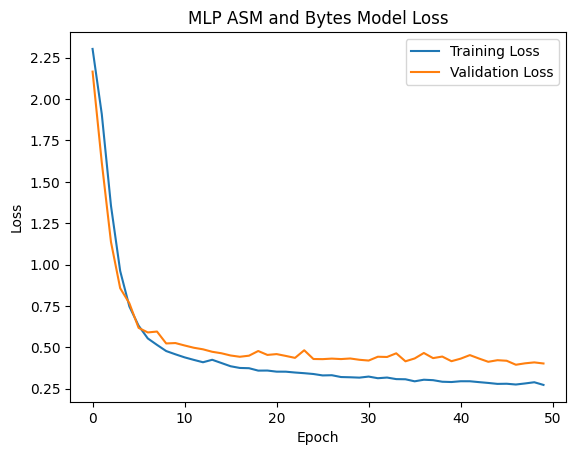

In [ ]:
# plot training & validation loss values
plt.plot(history_all.history['loss'], label='Training Loss')
plt.plot(history_all.history['val_loss'], label='Validation Loss')
plt.title('MLP ASM and Bytes Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

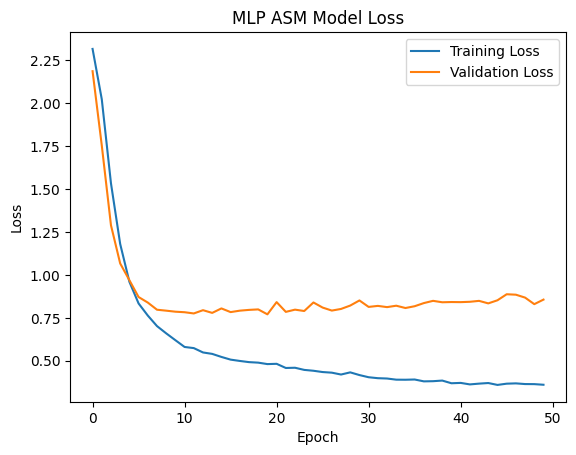

In [ ]:
# plot training & validation loss values
plt.plot(history_asm.history['loss'], label='Training Loss')
plt.plot(history_asm.history['val_loss'], label='Validation Loss')
plt.title('MLP ASM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

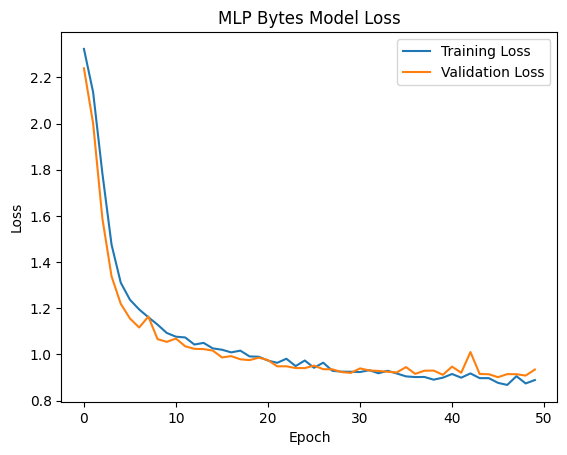

In [ ]:
# plot training & validation loss values
plt.plot(history_bytes.history['loss'], label='Training Loss')
plt.plot(history_bytes.history['val_loss'], label='Validation Loss')
plt.title('MLP Bytes Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred_prob_all = model_all.predict(X_test_all, verbose=False)
y_pred_all = np.argmax(y_pred_prob_all, axis=1) + 1
y_true_all = np.argmax(y_test_one_hot_all, axis=1) + 1
y_pred_prob_asm = model_asm.predict(X_test_asm, verbose=False)
y_pred_asm = np.argmax(y_pred_prob_asm, axis=1) + 1
y_true_asm = np.argmax(y_test_one_hot_asm, axis=1) + 1
y_pred_prob_bytes = model_bytes.predict(X_test_bytes, verbose=False)
y_pred_bytes = np.argmax(y_pred_prob_bytes, axis=1) + 1
y_true_bytes = np.argmax(y_test_one_hot_bytes, axis=1) + 1

## ASM and Bytes Confusion Matrix

In [ ]:
print(classification_report(y_true_all, y_pred_all, zero_division=0))

              precision    recall  f1-score   support

           1       0.97      0.93      0.95        40
           2       1.00      0.97      0.99        40
           3       1.00      0.97      0.99        40
           4       0.95      1.00      0.98        40
           5       0.95      1.00      0.98        40
           6       0.95      1.00      0.98        40
           7       1.00      0.95      0.97        40
           8       1.00      1.00      1.00        40

    accuracy                           0.98       320
   macro avg       0.98      0.98      0.98       320
weighted avg       0.98      0.98      0.98       320



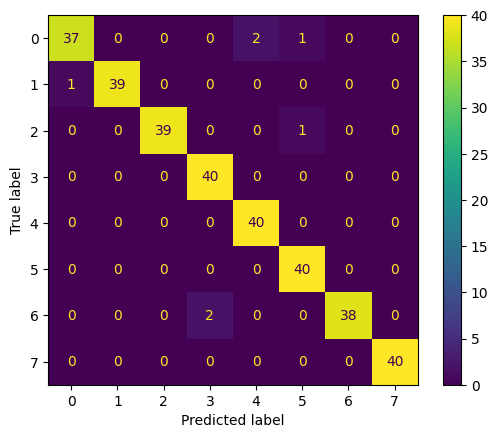

In [ ]:
# confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)
ConfusionMatrixDisplay(cm).plot()

## ASM Confusion Matrix

In [ ]:
print(classification_report(y_true_asm, y_pred_asm, zero_division=0))

              precision    recall  f1-score   support

           1       0.88      0.93      0.90        40
           2       1.00      0.90      0.95        40
           3       0.97      0.97      0.97        40
           4       1.00      0.97      0.99        40
           5       0.89      0.97      0.93        40
           6       0.97      0.95      0.96        40
           7       0.94      0.85      0.89        40
           8       0.89      0.97      0.93        40

    accuracy                           0.94       320
   macro avg       0.94      0.94      0.94       320
weighted avg       0.94      0.94      0.94       320



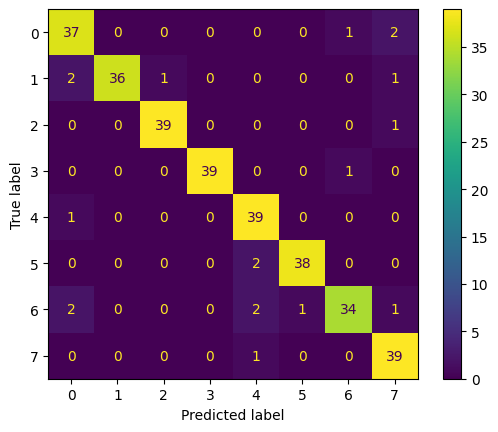

In [ ]:
# confusion matrix
cm = confusion_matrix(y_true_asm, y_pred_asm)
ConfusionMatrixDisplay(cm).plot()

## Bytes Confusion Matrix

In [ ]:
print(classification_report(y_true_bytes, y_pred_bytes, zero_division=0))

              precision    recall  f1-score   support

           1       0.57      0.75      0.65        40
           2       0.78      0.78      0.78        40
           3       1.00      0.97      0.99        40
           4       0.85      1.00      0.92        40
           5       0.73      0.47      0.58        40
           6       0.95      0.88      0.91        40
           7       0.67      0.75      0.71        40
           8       0.76      0.62      0.68        40

    accuracy                           0.78       320
   macro avg       0.79      0.78      0.78       320
weighted avg       0.79      0.78      0.78       320



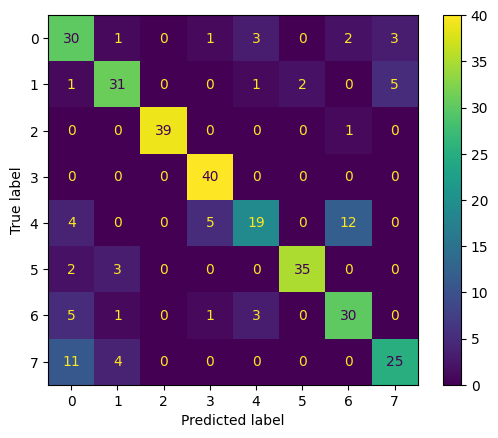

In [ ]:
# confusion matrix
cm = confusion_matrix(y_true_bytes, y_pred_bytes)
ConfusionMatrixDisplay(cm).plot()

## ASM and Bytes MLogLoss

In [ ]:
from sklearn.metrics import log_loss
# Calculate the mlogloss
mlogloss_all = log_loss(y_test_one_hot_all, y_pred_prob_all)
print(f"Multiclass Log Loss: {mlogloss_all}")

Multiclass Log Loss: 0.2405776637104365


## ASM MLogLoss

In [ ]:
# Calculate the mlogloss
mlogloss_asm = log_loss(y_test_one_hot_asm, y_pred_prob_asm)
print(f"Multiclass Log Loss: {mlogloss_asm}")

Multiclass Log Loss: 0.4559629943864458


## Bytes MLogLoss

In [ ]:
# Calculate the mlogloss
mlogloss_bytes = log_loss(y_test_one_hot_bytes, y_pred_prob_bytes)
print(f"Multiclass Log Loss: {mlogloss_bytes}")

Multiclass Log Loss: 0.7538467395477495


## Save the Models

In [ ]:
model_all.save('mlp_all.h5')
model_asm.save('mlp_asm.h5')
model_bytes.save('mlp_bytes.h5')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


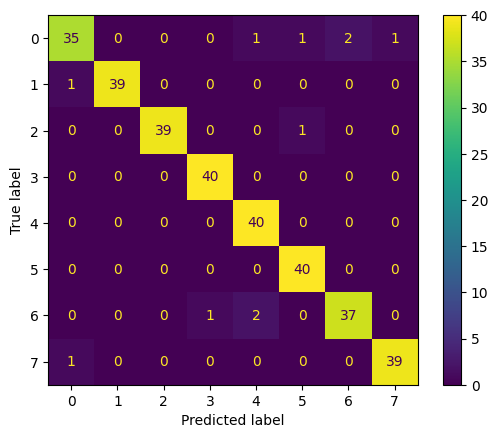

In [ ]:
# prompt: loading a saved model

# Load the saved models
model_all_test = tf.keras.models.load_model('mlp_all.h5')
model_asm_test = tf.keras.models.load_model('mlp_asm.h5')
model_bytes_test = tf.keras.models.load_model('mlp_bytes.h5')

# Now you can use the loaded models for prediction or further training
# Example:
y_pred_all_test = np.argmax(model_all.predict(X_test_all), axis = 1) + 1

# confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all_test)
ConfusionMatrixDisplay(cm).plot()

In [21]:
from tensorflow.keras.models import Model
# Extract embeddings from each model
mlp_all_embedding = tf.keras.models.load_model('mlp_all.h5')
mlp_asm_embedding = tf.keras.models.load_model('mlp_asm.h5')
mlp_bytes_embedding = tf.keras.models.load_model('mlp_bytes.h5')

mlp_all_embedding = Model(inputs=mlp_all_embedding.inputs, outputs=mlp_all_embedding.layers[-2].output)
mlp_asm_embedding = Model(inputs=mlp_asm_embedding.inputs, outputs=mlp_asm_embedding.layers[-2].output)
mlp_bytes_embedding = Model(inputs=mlp_bytes_embedding.inputs, outputs=mlp_bytes_embedding.layers[-2].output)

mlp_all_embeddings = mlp_all_embedding.predict(X_test_all)
mlp_asm_embeddings = mlp_asm_embedding.predict(X_test_asm)
mlp_bytes_embeddings = mlp_bytes_embedding.predict(X_test_bytes)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [35]:
y_pred_prob_all = mlp_all_embedding.predict(X_test_all, verbose=False)
y_pred_all = np.argmax(y_pred_prob_all, axis=1) + 1
y_true_all = np.argmax(y_test_one_hot_all, axis=1) + 1
y_pred_prob_asm = mlp_asm_embedding.predict(X_test_asm, verbose=False)
y_pred_asm = np.argmax(y_pred_prob_asm, axis=1) + 1
y_true_asm = np.argmax(y_test_one_hot_asm, axis=1) + 1
y_pred_prob_bytes = mlp_bytes_embedding.predict(X_test_bytes, verbose=False)
y_pred_bytes = np.argmax(y_pred_prob_bytes, axis=1) + 1
y_true_bytes = np.argmax(y_test_one_hot_bytes, axis=1) + 1

<ipython-input-53-e9106cd51482>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", num_classes_all)  # Choose a colormap with distinct colors


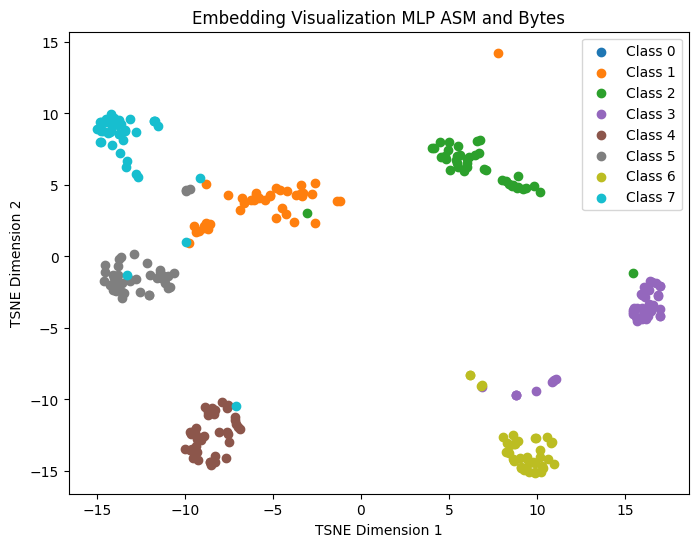

In [53]:
# Embedding Visualization ASM + Bytes
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

class_labels_all = y_true_all

tsne_all = TSNE(n_components=2)
embeddings_2d_all = tsne_all.fit_transform(mlp_all_embeddings)

plt.figure(figsize=(8, 6))
num_classes_all = len(set(class_labels_all))  # Total number of unique classes
colors = plt.cm.get_cmap("tab10", num_classes_all)  # Choose a colormap with distinct colors

for class_index in range(num_classes_all):
    # Select points for the current class
    indices = np.where(np.array(class_labels_all) == class_index)
    plt.scatter(
        embeddings_2d_all[indices, 0],
        embeddings_2d_all[indices, 1],
        label=f"Class {class_index}",
        color=colors(class_index)
    )

plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')
plt.title('Embedding Visualization MLP ASM and Bytes')
plt.legend()
plt.show()

<ipython-input-54-75e03e5aa7d5>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", num_classes_asm)  # Choose a colormap with distinct colors


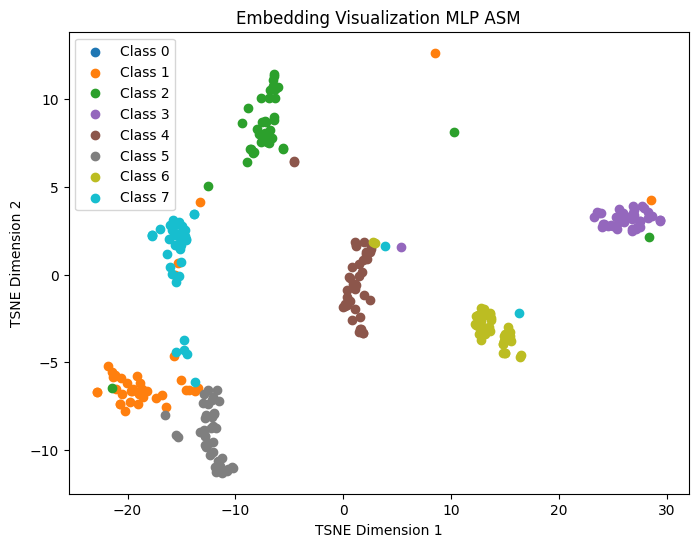

In [54]:
# Embedding Visualization ASM
class_labels_asm = y_true_asm

tsne_asm = TSNE(n_components=2)
embeddings_2d_asm = tsne_asm.fit_transform(mlp_asm_embeddings)

plt.figure(figsize=(8, 6))
num_classes_asm = len(set(class_labels_asm))  # Total number of unique classes
colors = plt.cm.get_cmap("tab10", num_classes_asm)  # Choose a colormap with distinct colors

for class_index in range(num_classes_asm):
    # Select points for the current class
    indices = np.where(np.array(class_labels_asm) == class_index)
    plt.scatter(
        embeddings_2d_asm[indices, 0],
        embeddings_2d_asm[indices, 1],
        label=f"Class {class_index}",
        color=colors(class_index)
    )

plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')
plt.title('Embedding Visualization MLP ASM')
plt.legend()
plt.show()

<ipython-input-55-e8a031f2d7c6>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", num_classes_bytes)  # Choose a colormap with distinct colors


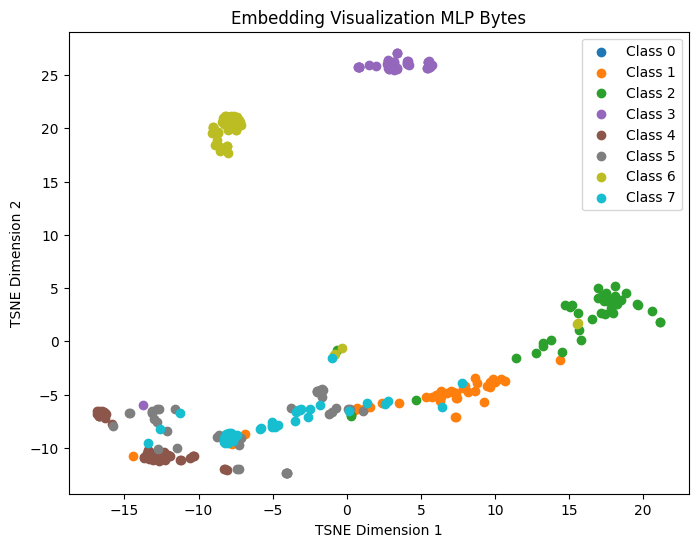

In [55]:
# Embedding Visualization Bytes
class_labels_bytes = y_true_bytes

tsne_bytes = TSNE(n_components=2)
embeddings_2d_bytes = tsne_bytes.fit_transform(mlp_bytes_embeddings)

plt.figure(figsize=(8, 6))
num_classes_bytes = len(set(class_labels_bytes))  # Total number of unique classes
colors = plt.cm.get_cmap("tab10", num_classes_bytes)  # Choose a colormap with distinct colors

for class_index in range(num_classes_bytes):
    # Select points for the current class
    indices = np.where(np.array(class_labels_bytes) == class_index)
    plt.scatter(
        embeddings_2d_bytes[indices, 0],
        embeddings_2d_bytes[indices, 1],
        label=f"Class {class_index}",
        color=colors(class_index)
    )

plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')
plt.title('Embedding Visualization MLP Bytes')
plt.legend()
plt.show()